In [1]:
import numpy as np               
import matplotlib.pyplot as plt  
import sklearn.gaussian_process as gp

# ベイズ推定とガウス過程モデル

In [2]:
# カーネル関数 k(x,x') を定義
def GPk(xv,zv,sd=1):
    return(np.outer(xv,zv) + sd**2 * np.equal.outer(xv,zv))

In [3]:
n, sd =30, 0.5;  # 設定
theta = 1           # 回帰係数
# データ生成
X = np.random.normal(scale=3,size=n)
Yob = np.dot(X,theta) + np.random.normal(scale=sd,size=n)
newx = np.linspace(X.min(),X.max(),100) # 予測点 
# カーネル関数の計算
Kob  = GPk(X,X,sd=sd)
kx   = GPk(newx,X,sd=sd)
knewx = GPk(newx,newx,sd=sd)
# ガウス過程による回帰関数の予測
GPf = np.dot(kx, np.linalg.solve(Kob,Yob))
GPv =  np.maximum(np.diag(knewx- np.dot(kx, np.linalg.solve(Kob,kx.T))),0)

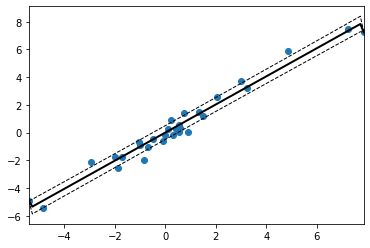

In [4]:
# プロット
plt.xlim(X.min(),X.max())
plt.scatter(X,Yob)                   # データ点
plt.plot(newx, GPf, 'k-', lw=2)  # 推定した回帰関数
# 信頼区間
plt.plot(newx, GPf+np.sqrt(GPv), 'k--', lw=1)
plt.plot(newx, GPf-np.sqrt(GPv), 'k--', lw=1)
plt.show()

# ガウス過程モデルによる回帰分析

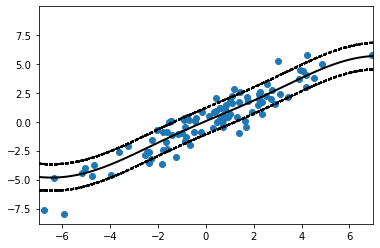

In [5]:
# トレーニングデータの生成
n, sd = 100, 1    # 設定
theta = 1            #  回帰係数
X = np.random.normal(scale=3, size=n).reshape(n,-1)
Yob = np.dot(X,theta) + np.random.normal(scale=sd,size=n).reshape(n,-1)
# カーネル関数の定義：ガウスカーネル + ホワイトカーネル
kk = gp.kernels.RBF() + gp.kernels.WhiteKernel()
gpm = gp.GaussianProcessRegressor(kernel=kk)
gpm.fit(X, Yob)                                # データへのフィッティング
newx = np.linspace(-7,7,100).reshape(100,-1)   # 予測点
GPf, GPv = gpm.predict(newx, return_cov=True)  # 予測値と分散共分散行列
GPsd = np.sqrt(np.diag(GPv))                   # 予測値の標準偏差
# プロット
plt.xlim(-7,7)
plt.scatter(X,Yob)
plt.plot(newx, GPf,'k-', lw=2)
plt.plot(newx, GPf+GPsd,'k--', lw=1)
plt.plot(newx, GPf-GPsd,'k--', lw=1)
plt.show()

# ガウス過程モデルによる判別分析

/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


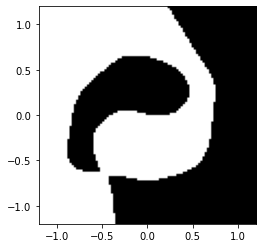

In [6]:
from common import mlbench as ml                      # code_mlbench.spirals を使う
X, y = ml.spirals(200,cycles=1.2,sd=0.16)           # データ生成
kk = gp.kernels.RBF()+gp.kernels.WhiteKernel()  # カーネル設定
gpm = gp.GaussianProcessClassifier(kernel=kk)
gpm.fit(X,y)                              # データ・フィッティング
m = 100; newx = np.linspace(-1.2,1.2,m)   # 予測点生成
newdat = np.array([(y, x) for x in newx for y in newx])
GPpred = gpm.predict(newdat)              # 予測ラベル
# プロット
ext=(-1.2,1.2,-1.2,1.2)
plt.imshow(GPpred.reshape(m,-1)[::-1],cmap='gray',extent=ext)
plt.show()

# ベイズ最適化

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from skopt import gp_minimize
from scipy.spatial import distance           # distanceの計算

X,y = ml.spirals(200,cycles=1,sd=0.1,label=[0,1]) # データ生成

# 目的関数を定義
def svmcv(par):
    logC, logsig = par
    sv = SVC(kernel="rbf", gamma=10**logsig, C=10**logC)
    cv = cross_validate(sv,X,y,scoring='accuracy',cv=5)
    return(1-np.mean(cv['test_score']))

# カーネル幅の範囲をデータから決める
from scipy.spatial import distance               # distanceの計算
cg = np.log10(1/np.percentile(distance.pdist(X),[1,99])**2)
space = [(-5.,5.), (cg[1],cg[0])]

x0 = [0., np.mean(cg)]
op = gp_minimize(svmcv,space,x0=x0,acq_func="EI",n_calls=100,verbose=True)

Iteration No: 1 started. Evaluating function at provided point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 0.0105
Function value obtained: 0.3900
Current minimum: 0.3900
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0133
Function value obtained: 0.6700
Current minimum: 0.3900
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0132
Function value obtained: 0.7400
Current minimum: 0.3900
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0092
Function value obtained: 0.4000
Current minimum: 0.3900
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0130
Function value obtained: 0.4250
Current minimum: 0.3900
Iteration No: 6 started. Evalua

/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4242
Function value obtained: 0.3300
Current minimum: 0.3300
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.1016
Function value obtained: 0.3400
Current minimum: 0.3300
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.2220
Function value obtained: 0.3250
Current minimum: 0.3250
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.2012
Function value obtained: 0.3450
Current minimum: 0.3250
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.1084
Function value obtained: 0.4650
Current minimum: 0.3250
Iteration No: 27 started. Sea

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 0.2372
Function value obtained: 0.3200
Current minimum: 0.2950
Iteration No: 63 started. Searching for the next optimal point.
Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 0.1975
Function value obtained: 0.3000
Current minimum: 0.2950
Iteration No: 64 started. Searching for the next optimal point.
Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 0.1995
Function value obtained: 0.4650
Current minimum: 0.2950
Iteration No: 65 started. Searching for the next optimal point.
Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 0.2055
Function value obtained: 0.4700
Current minimum: 0.2950
Iteration No: 66 started. Searching for the next optimal point.
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 0.4807
Function value obtained: 0.3900
Current minimum: 0.2950
Iteration No: 67 started. Sea

In [8]:
optC,optsig = 10**np.array(op.x)
optC,optsig

(2725.063634932011, 0.289407430347861)

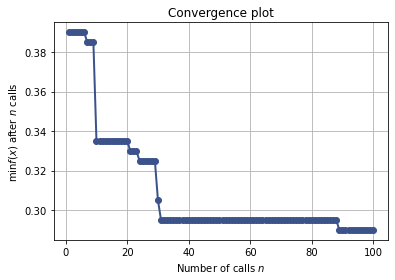

In [9]:
from skopt.plots import plot_convergence
plot_convergence(op)
plt.show()